# Exploratory Data Analysis - covariants
by __Pawel Rosikiewicz__ 

---

## Setup
---

In [1]:
import os
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn import set_config
from sklearn.preprocessing import FunctionTransformer # creates custom transfomers
from sklearn.pipeline import make_pipeline, Pipeline # like pipeline function, but give step names automatically, 
from sklearn.compose import ColumnTransformer # allows using different transformers to different columns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer # skleanr transformers,

In [2]:
# basedir
basedir = os.path.dirname(os.getcwd())
os.chdir(basedir)
sys.path.append(basedir)

In [3]:
# paths
PATH_data_raw     = os.path.join(basedir, "data/raw")
PATH_data_interim = os.path.join(basedir, "data/interim")
PATH_results      = os.path.join(basedir, "data/results")
PATH_models       = os.path.join(basedir, "models")

In [4]:
# load custom functions
from src.utils.DataFrameExplorer import DataFrameExplorer_summary as dfe # plots with pandas df summary
from src.utils.DataFrameExplorer import DataFrameExplorer_features as dfe_features # provides data examples 
from src.utils.DataFrameExplorer import DataFrameExplorer_cleaning as dfe_cleaning # used for data cleanign and formatting
from src.utils.DataFrameExplorer import DataFrameExplorer_duplicates as dfe_duplicates # used to detect column duplicates

# modificaitons of my older scripts created for this project 
from src.utils.DataFrameExplorer_modif import DataFrameExplorer_groups as dfe_groups # plots comparing two or more dataframes

### define variable groups in covariant data
* it was done using Notebook 01 a

In [5]:
# main variable groups, and types
VAR_GROUPS = dict(
    TARGET_VAR = ["target"],
    CATEGORICAL_VAR = [ 'Baseline ECOG Score', 'Enrollment IC', 'IC Level', 'TC Level', 'Immune phenotype', 'Sex',
           'TCGA Subtype', 'Lund', 'Lund2', 'Received platinum',
           'Met Disease Status', 'Sample age', 'Sample collected pre-platinum',
           'Intravesical BCG administered', 'Tobacco Use History'],
    QUANTITATIVE_VAR = ['FMOne mutation burden per MB', 'Neoantigen burden per MB'],
)

# variable encoding in data_cov
VAR_DTYPES = {
    "TARGET_VAR": "int", # only for EDA
    "CATEGORICAL_VAR": "O",
    "QUANTITATIVE_VAR": "float64"
}

# target variable encoding
TARGET_ENCODING = {0:"non-responder", 1:"responder"}

# list potential confounding variables, used to stratify the results
CONFOUNDING_VAR = ['Sex', 'Tobacco Use History']

## Step 1. Load the data

In [6]:
from src.utils.helper_data_loaders import load_tsv

# load target data
data_cov =  load_tsv(PATH_data_raw, 'X_covariates.tsv')
data_genes = load_tsv(PATH_data_raw, 'X_genes.tsv')
target = load_tsv(PATH_data_raw, 'y.tsv', header=None)

# small correction
target.columns=[VAR_GROUPS["TARGET_VAR"][0]]

(200, 17)
(200, 31085)
(200, 1)


### inspect loaded dataset - full QC is in Step 3.
__expected data:__ 
* we expect to have dataframe with normalized RNA-sequencing data (TPM values for 31085 genes)
* TPM (Transcripts Per Kilobase Million) are explained here: https://youtu.be/TTUrtCY2k-w, or in my notes: https://github.com/PawelRosikiewicz/Ardigen/blob/main/notes/Pawel_Rosikiewicz_RNAseq_data_anylsis_NOTES.pdf


In [7]:
# missing data
data_genes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Columns: 31085 entries, TPM_hugo_A1BG to TPM_hugo_ZZZ3
dtypes: float64(31085)
memory usage: 47.4 MB


In [8]:
# shape
print("shape:", data_genes.shape)
# missing data
print("missing data nr:", data_genes.isnull().sum().sum())
# example
data_genes.head()

shape: (200, 31085)
missing data nr: 0


,TPM_hugo_A1BG,TPM_hugo_A1BG-AS1,TPM_hugo_A1CF,TPM_hugo_A2M,TPM_hugo_A2M-AS1,TPM_hugo_A2ML1,TPM_hugo_A2MP1,TPM_hugo_A3GALT2,TPM_hugo_A4GALT,TPM_hugo_A4GNT,...,TPM_hugo_ZWILCH,TPM_hugo_ZWINT,TPM_hugo_ZXDA,TPM_hugo_ZXDB,TPM_hugo_ZXDC,TPM_hugo_ZYG11A,TPM_hugo_ZYG11B,TPM_hugo_ZYX,TPM_hugo_ZZEF1,TPM_hugo_ZZZ3
0,1.564289,2.711834,0.0,599.387994,2.354073,43.245808,0.0,0.000000,11.437090,0.070903,...,8.574489,6.467672,1.906227,3.293924,8.333586,2.189232,19.280571,168.266220,27.175332,17.836860
1,3.487859,1.717013,0.0,222.711937,2.288359,5.718716,0.0,0.564476,6.026609,0.108688,...,10.409939,3.572365,2.761780,3.411667,9.293182,1.813353,21.761841,66.403339,21.311923,22.296492
2,0.613334,0.508520,0.0,204.222937,0.627338,300.472716,0.0,0.000000,11.797474,0.040773,...,6.272013,3.109443,1.068439,2.559726,5.181549,0.225283,15.800051,172.944084,14.743828,18.920023
3,2.385017,1.600782,0.0,1851.589619,3.301540,1.346349,0.0,0.000000,23.938826,0.000000,...,4.586123,1.150169,1.464567,1.386418,4.501980,0.036808,11.444219,116.271619,19.222790,11.936066
4,1.964353,0.791064,0.0,982.752783,0.589165,85.088254,0.0,0.096887,17.058419,0.447727,...,4.292896,2.469881,1.809374,3.056738,6.604204,0.436553,20.036719,143.793153,24.820985,17.297542


## Step 3. Data Preparation
---

In [9]:
# create custom transformer
log_scale_transformer = make_pipeline( 
    FunctionTransformer(np.log1p, validate=False), # creates runtime warning if negative data are used
)

# transform the data
data_genes_log = pd.DataFrame(
    log_scale_transformer.fit_transform(data_genes),
    columns=data_genes.columns
)

### Step 4. Quality control on raw and transformed data
---

__import my fuctions prepared for that task__

In [10]:
from src.utils.helper_boxplot import colored_boxplots
from src.utils.helper_tpm_summary import tpm_summary
from src.utils.helper_tpm_summary import tpm_plots
from src.utils.helper_cluster_histogram import spearman_clustermap

### __Examine TPM values__
* done before and after different transformaitons, cleanirng and filtering

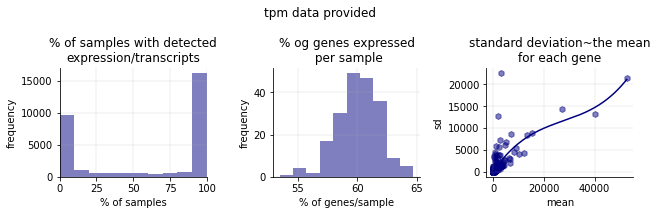

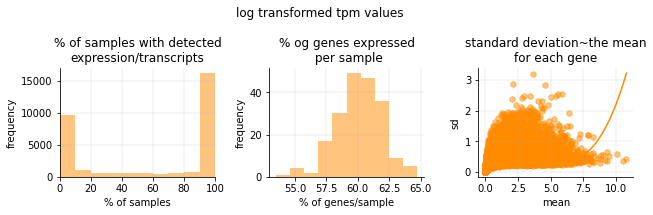

In [11]:
tpm_plots( df=data_genes, deg=3, title="tpm data provided")
tpm_plots( df=data_genes_log, title="log transformed tpm values", deg=3, color="darkorange")

__show summary table__

In [12]:
tpm_summary_raw = tpm_summary( df=data_genes, hue=target.iloc[:,0].values)
tpm_summary_log = tpm_summary( df=data_genes_log, hue=target.iloc[:,0].values)
pd.concat(
    [tpm_summary_raw.transpose(),tpm_summary_log.transpose()],
    keys=["raw", "log"], 
    axis=1
)

raw              log  \
                                                         0         1      0   
sample nr                                              154        46    154   
gene nr                                              31085     31085  31085   
- VALUES -                                                                    
min tpm value recorded                                 0.0       0.0    0.0   
median tpm value recorded                              0.3       0.3    0.3   
mean tpm value recorded                               32.2      32.2    1.3   
max tpm value recorded                            314419.1  145264.8   12.7   
- DETECTED IN -                                                               
mean % of genes expressed per sample                 60.1%     60.0%  60.1%   
% of genes not expressed in any sample               18.3%     22.4%  18.3%   
% of genes expressed in at least 50%  of samples     59.5%     59.7%  59.5%   
% of genes expressed in all samples                  43.9%     46.9%  43.9%   

                                                         
                                                      1  
sample nr                                            46  
gene nr                                           31085  
- VALUES -                                               
min tpm value recorded                              0.0  
median tpm value recorded                           0.3  
mean tpm value recorded                             1.3  
max tpm value recorded                             11.9  
- DETECTED IN -                                          
mean % of genes expressed per sample              60.0%  
% of genes not expressed in any sample            22.4%  
% of genes expressed in at least 50%  of samples  59.7%  
% of genes expressed in all samples               46.9%

__show TPM levels for the first 100 genes__

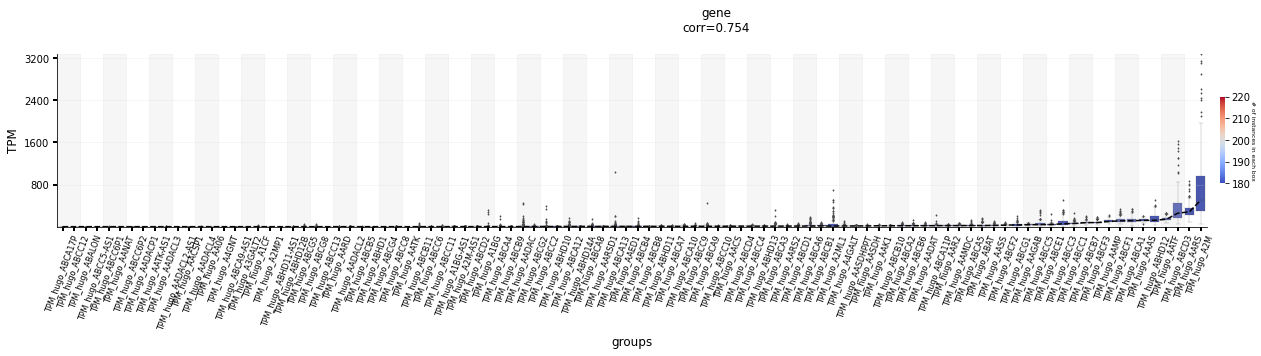

In [13]:
# how many genes to display
n = 100

# just range
bt_data = data_genes.iloc[:,0:n].transpose().copy(); 
bt_data = bt_data.stack().reset_index(drop=False)
bt_data.columns = ["gene", "sample", "TPM"]

# set parameters for boxlot,
bt_dct = dict(figsize=(20,5), order=True, 
        cmap="coolwarm", patch_width=2, max_x_labels=None, labelsize=12)

# create boxplot for each categorical variable + tagret variable
colored_boxplots(
    df=bt_data, 
    yvar="TPM", 
    xvars="gene",
    
    bt_dct = bt_dct
)

## __Check for sample outliers__

__Methods__
* inspiration for plots from: https://www.kaggle.com/code/sgalella/correlation-heatmaps-with-hierarchical-clustering/notebook
* https://seaborn.pydata.org/generated/seaborn.clustermap.html
* add second row_color to sns.clustermap https://stackoverflow.com/questions/61816216/seaborn-clustermap-with-two-row-colors






### __Sample distances__
* __GOAL__: 
    * to assess overall similarity between samples: 
    * Which samples are similar to each other, which are different? 
    * Does this fit to the expectation from the experiment’s design?

* __METHOD__:
    * pair-wise comparisons done with 
    * 

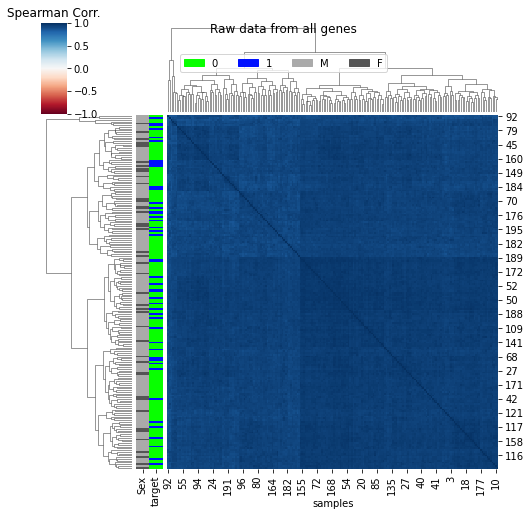

In [20]:
spearman_clustermap(
    df=data_genes_log.transpose(), 
    labels=pd.Series(target.iloc[:,0]),  #
    labels_2=pd.Series(data_cov.loc[:,"Sex"]),  #
    n=100, 
    figsize=(7,7),
    title="Raw data from all genes"
)

__Find potential outliers__

__Rank-based filtering with Spearman correlation__
* in this approach, i create an average gene expression profile for each group of samples, including potential stratificaiton, 
* secondl, I calulate speerman rho, correlation coef, for each sample, that rank based, 
* and I remove the samples that are below threshold, 
* the threshold is parametrized    

__Comment__
* the same method is used, to provide informaiton on sample quality in prediciton pipeline


In [ ]:
y = 
X = 



In [ ]:
target.

In [70]:
class SpearmanFilter():
    '''
        .............................................................
        Custom made transformer for House Price Data
        .............................................................
        
        FUNCTIONS
        . fit_transform()        : see below fit transfomed policy
        . transform()        : see below fit transfomed policy
        . get_df_summary(self)   : returns summary of df before and after fit transform (pd.DataFrame)
        . get_params(self)       : it will return all parameters, including df summary
    '''

    # private methods and variables, 
    def __init__(self, Tr=0.9):
        self._distance_Tr=Tr # its 1-speakerm corr. with the mean, sample 
        self._median_sample_profiles=dict()# contains median profiles with 
    
    
    # Method,.....................................
    def fit(self, x, y):
        ''' its 1-speakerm corr. with the mean, sample
        '''
        # Test input df,
        assert type(x) == pd.DataFrame, "Incorrect obj type: x shoudl be pd.Series"
        assert type(y) == pd.Series, "Incorrect obj type: y shoudl be pd.Series"

        # dct for the results
        median_profile_per_target_class = dict() 

        # calulate average gene expression profile in each target class
        labels_unique = y.unique()
        for label_name in labels_unique:
            # subset the data
            xsub = x.loc[y==label_name,:]
            # create an everage expression profile for each gene in a target group
            mean_profile = xsub.apply(np.median, axis=0)
            # place it in dict
            self._median_sample_profiles[label_name]=mean_profile       
    
        return median_profile_per_target_class

    
        
        
        
    
    
    
    
    
    

In [68]:
rf = SpearmanFilter()
rf.fit_transform()

TypeError: fit_transform() missing 3 required positional arguments: 'x', 'y', and 'Tr'

In [72]:
# data
x = data_genes_log
y = pd.Series(target.iloc[:,0])
Tr = 0.9

# dct for the results
median_sample_profiles = dict() 
sample_qc = dict()



# Test input df,
assert type(x) == pd.DataFrame, "Incorrect obj type: x shoudl be pd.Series"
assert type(y) == pd.Series, "Incorrect obj type: y shoudl be pd.Series"

# calulate average gene expression profile in each target class
labels_unique = y.unique()
for label_name in labels_unique:
    
    # ... part 1. - fit - calulate mean profle in each gorup
    
    # subset the data
    xsub = x.loc[y==label_name,:]
    # create an everage expression profile for each gene in a target group
    mean_profile = xsub.apply(np.median, axis=0)
    # place it in dict
    median_sample_profiles[label_name]=mean_profile        
    
    # ... part 2. - transform - compare each sample to the mean profile
    
    
    

    
    
    
    
    
    
    
    
    
    
    
    
    

In [74]:
for index in x.sub.shape[0]:
    pd.concat([xsub.iloc[:, index], ], axis=0)

TPM_hugo_A1BG        0.779252
TPM_hugo_A1BG-AS1    0.649518
TPM_hugo_A1CF        0.000000
TPM_hugo_A2M         6.107122
TPM_hugo_A2M-AS1     0.723878
                       ...   
TPM_hugo_ZYG11A      0.361199
TPM_hugo_ZYG11B      3.134744
TPM_hugo_ZYX         4.339951
TPM_hugo_ZZEF1       3.240704
TPM_hugo_ZZZ3        3.086378
Length: 31085, dtype: float64

In [99]:
dfs = pd.concat([xsub,pd.DataFrame(mean_profile).transpose()], axis=1)

In [ ]:
pd.Series(mean_profile)